# Eval domain adaptation exp2.2

## Environment setup

In [1]:
!pip -q install -U transformers datasets accelerate evaluate scikit-learn

import json, math, os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Dict, Any

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 56.9 MB/s eta 0:00:00
Device: cuda


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Target label schema

In [13]:
# 9-label order MUST match what you trained with
TARGET_LABELS = ["anger","anticipation","caring","disgust","fear","joy","neutral","sadness","surprise"]
label2id = {l:i for i,l in enumerate(TARGET_LABELS)}
id2label = {i:l for l,i in label2id.items()}
NUM_LABELS = len(TARGET_LABELS)

# ✅ Put your FINAL distilled model here
FINAL_MODEL_PATH = "/content/drive/MyDrive/VibeQ-EIE/models/student_distilled_9_v3"

# Optional: baseline model path to compare (GoEmotions-only mapped-to-9)
BASELINE_MODEL_PATH = "/content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1"

# ✅ Your 270 journals file (JSONL recommended)
# Expected schema per row (at minimum):
# - "text" (or "journal")
# - "primary_emotion"   (teacher hard label)
# - optional "teacher_emotion_probs" dict with 9 keys (soft probs)
JOURNAL_TEST_PATH = "/content/drive/MyDrive/VibeQ-EIE/llmdata/teacher_journals_distillation_v2_test.jsonl"

MAX_LENGTH = 192
BATCH_SIZE = 64


## JSONL loading helpers

In [14]:
def load_jsonl(path: str) -> List[Dict[str, Any]]:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

rows = load_jsonl(JOURNAL_TEST_PATH)
print("Loaded rows:", len(rows))
print("Example keys:", list(rows[0].keys()))
print("Example row:", {k: rows[0][k] for k in rows[0].keys() if k in ["text","journal","primary_emotion","teacher_emotion_probs"]})


Loaded rows: 270
Example keys: ['primary_emotion', 'secondary_emotions', 'teacher_emotion_probs', 'vad', 'teacher_confidence', 'text', '_seed_domain', '_seed_trigger', '_seed_pov']
Example row: {'primary_emotion': 'anger', 'teacher_emotion_probs': {'anger': 0.85, 'anticipation': 0.1, 'caring': 0.0, 'disgust': 0.05, 'fear': 0.0, 'joy': 0.0, 'neutral': 0.0, 'sadness': 0.0, 'surprise': 0.0}, 'text': "I waited three days for the edit link to drop in my inbox, just like they said it would after I paid. Then yesterday, a canned message: 'Unexpected delays.' No apology, no timeline—just a footnote at the bottom saying the beta team’s 'prioritizing key stakeholders.' I rewrote my bio twice so I’d look serious when applying to grad programs. Now I’m stuck with a profile full of typos, and zero reply from support since Tuesday."}


## Normalize incoming rows

In [15]:
def normalize_row(r: Dict[str, Any]) -> Dict[str, Any]:
    # text key variants
    text = r.get("text")
    if not isinstance(text, str):
        text = r.get("journal") or r.get("journal_entry") or r.get("entry")
    if not isinstance(text, str):
        text = ""
    text = text.strip()

    # teacher hard label
    pe = r.get("primary_emotion")
    if isinstance(pe, str):
        pe = pe.strip().lower()
    else:
        pe = None

    # teacher probs (optional)
    tp = r.get("teacher_emotion_probs")
    teacher_probs = None
    if isinstance(tp, dict):
        # strict 9-key order
        try:
            teacher_probs = [float(tp[k]) for k in TARGET_LABELS]
            s = sum(teacher_probs)
            if s > 0:
                teacher_probs = [x/s for x in teacher_probs]
            else:
                teacher_probs = None
        except KeyError:
            teacher_probs = None

    return {
        "text": text,
        "teacher_label": pe,
        "teacher_probs": teacher_probs
    }

data = [normalize_row(r) for r in rows]
# Filter out bad rows
data = [d for d in data if len(d["text"]) >= 5 and d["teacher_label"] in label2id]
print("Valid rows after filtering:", len(data))

# Stats: how many have teacher_probs?
has_probs = sum(1 for d in data if d["teacher_probs"] is not None)
print("Rows with teacher_probs:", has_probs)


Valid rows after filtering: 270
Rows with teacher_probs: 270


## Load trained and baseline models

In [16]:
def load_model(model_path: str):
    tok = AutoTokenizer.from_pretrained(model_path)
    mdl = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id,
    ).to(DEVICE)
    mdl.eval()
    return tok, mdl

final_tok, final_model = load_model(FINAL_MODEL_PATH)
print("Loaded FINAL model:", FINAL_MODEL_PATH)

baseline_tok, baseline_model = (None, None)
if BASELINE_MODEL_PATH:
    baseline_tok, baseline_model = load_model(BASELINE_MODEL_PATH)
    print("Loaded BASELINE model:", BASELINE_MODEL_PATH)


Loaded FINAL model: /content/drive/MyDrive/VibeQ-EIE/models/student_distilled_9_v3
Loaded BASELINE model: /content/drive/MyDrive/VibeQ-EIE/models/student_singlelabel_9emotions_v1


## Batched prediction helper

In [17]:
@torch.no_grad()
def predict_probs(tokenizer, model, texts: List[str], batch_size=64) -> np.ndarray:
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
        all_probs.append(probs)
    return np.concatenate(all_probs, axis=0)

texts = [d["text"] for d in data]
y_true = np.array([label2id[d["teacher_label"]] for d in data], dtype=np.int64)
teacher_probs = np.array(
    [d["teacher_probs"] if d["teacher_probs"] is not None else [np.nan]*NUM_LABELS for d in data],
    dtype=np.float32
)

final_probs = predict_probs(final_tok, final_model, texts, batch_size=BATCH_SIZE)
final_pred = final_probs.argmax(axis=-1)

print("final_probs shape:", final_probs.shape)


final_probs shape: (270, 9)


## Hard-label metrics

In [18]:
def eval_hard(y_true, y_pred, title=""):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    print(f"\n===== {title} =====")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1_macro, 4))
    print("F1-micro :", round(f1_micro, 4))
    print("\nPer-class report:\n", classification_report(y_true, y_pred, target_names=TARGET_LABELS, zero_division=0))
    return acc, f1_macro, f1_micro

final_acc, final_f1m, final_f1u = eval_hard(y_true, final_pred, title="FINAL vs Teacher Hard Labels (270 journals)")



===== FINAL vs Teacher Hard Labels (270 journals) =====
Accuracy : 0.9222
F1-macro : 0.92
F1-micro : 0.9222

Per-class report:
               precision    recall  f1-score   support

       anger       0.96      0.90      0.93        30
anticipation       0.85      0.97      0.91        30
      caring       0.97      0.93      0.95        30
     disgust       0.94      0.97      0.95        30
        fear       0.91      1.00      0.95        30
         joy       0.85      0.97      0.91        30
     neutral       0.97      0.97      0.97        30
     sadness       0.95      0.67      0.78        30
    surprise       0.93      0.93      0.93        30

    accuracy                           0.92       270
   macro avg       0.93      0.92      0.92       270
weighted avg       0.93      0.92      0.92       270



## Confusion matrix plotting

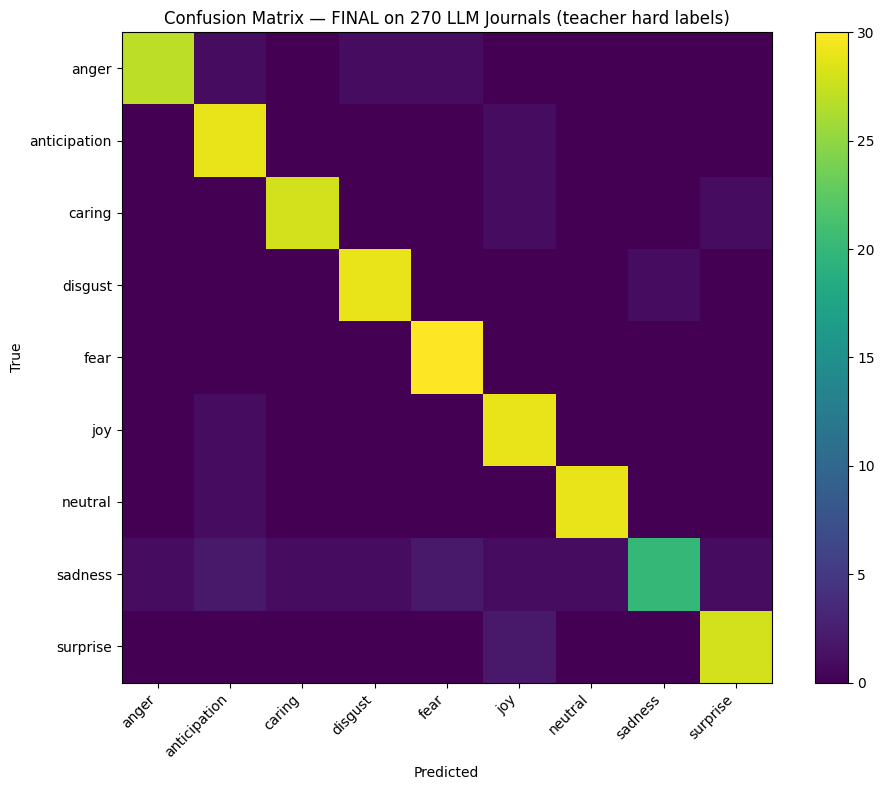

In [19]:
def plot_cm(cm, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(TARGET_LABELS))
    plt.xticks(tick_marks, TARGET_LABELS, rotation=45, ha="right")
    plt.yticks(tick_marks, TARGET_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

cm_final = confusion_matrix(y_true, final_pred, labels=np.arange(NUM_LABELS))
plot_cm(cm_final, "Confusion Matrix — FINAL on 270 LLM Journals (teacher hard labels)")


## Uncertainty diagnostics

In [20]:
def mean_kl_teacher_student(teacher_p: np.ndarray, student_p: np.ndarray, eps=1e-8) -> float:
    # KL(P_teacher || P_student)
    tp = np.clip(teacher_p, eps, 1.0)
    sp = np.clip(student_p, eps, 1.0)
    tp = tp / tp.sum(axis=1, keepdims=True)
    sp = sp / sp.sum(axis=1, keepdims=True)
    kl = np.sum(tp * (np.log(tp) - np.log(sp)), axis=1)
    return float(np.mean(kl))

def mean_ce_teacher_student(teacher_p: np.ndarray, student_p: np.ndarray, eps=1e-8) -> float:
    # Cross-entropy H(P_teacher, P_student) = -sum p_t log p_s
    tp = np.clip(teacher_p, eps, 1.0)
    sp = np.clip(student_p, eps, 1.0)
    tp = tp / tp.sum(axis=1, keepdims=True)
    sp = sp / sp.sum(axis=1, keepdims=True)
    ce = -np.sum(tp * np.log(sp), axis=1)
    return float(np.mean(ce))

mask = ~np.isnan(teacher_probs).any(axis=1)
print("Soft-prob rows available:", int(mask.sum()), "/", len(data))

if mask.sum() > 0:
    kl = mean_kl_teacher_student(teacher_probs[mask], final_probs[mask])
    ce = mean_ce_teacher_student(teacher_probs[mask], final_probs[mask])
    print("\n===== FINAL vs Teacher Soft Targets =====")
    print("Mean KL(P_teacher || P_student):", round(kl, 4))
    print("Mean Cross-Entropy:", round(ce, 4))
else:
    print("No teacher_probs found in the test file. Skipping KL/CE.")


Soft-prob rows available: 270 / 270

===== FINAL vs Teacher Soft Targets =====
Mean KL(P_teacher || P_student): 0.5789
Mean Cross-Entropy: 1.7261


## Confidence analysis


===== Calibration sanity =====
Avg max prob (confidence): 0.8532
Median max prob: 0.9079
Avg entropy: 0.5107
Median entropy: 0.397
Avg top1-top2 gap: 0.7719
Median gap: 0.8466


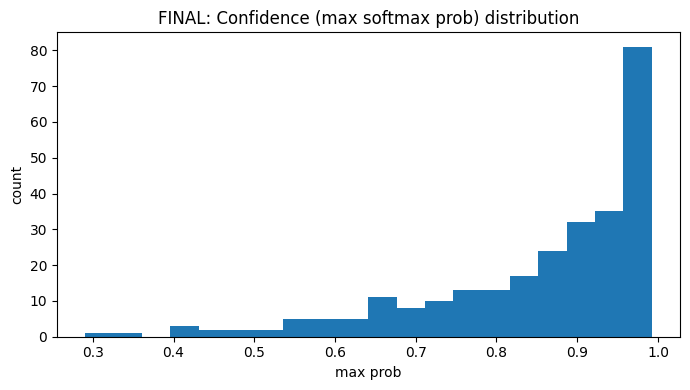

In [21]:
def entropy(p, eps=1e-8):
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

conf = final_probs.max(axis=1)
ent  = entropy(final_probs)
sorted_probs = np.sort(final_probs, axis=1)
gap = sorted_probs[:, -1] - sorted_probs[:, -2]

print("\n===== Calibration sanity =====")
print("Avg max prob (confidence):", round(float(conf.mean()), 4))
print("Median max prob:", round(float(np.median(conf)), 4))
print("Avg entropy:", round(float(ent.mean()), 4))
print("Median entropy:", round(float(np.median(ent)), 4))
print("Avg top1-top2 gap:", round(float(gap.mean()), 4))
print("Median gap:", round(float(np.median(gap)), 4))

plt.figure(figsize=(7,4))
plt.hist(conf, bins=20)
plt.title("FINAL: Confidence (max softmax prob) distribution")
plt.xlabel("max prob")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## Baseline comparison


===== BASELINE vs Teacher Hard Labels (270 journals) =====
Accuracy : 0.2259
F1-macro : 0.1871
F1-micro : 0.2259

Per-class report:
               precision    recall  f1-score   support

       anger       0.64      0.53      0.58        30
anticipation       0.67      0.07      0.12        30
      caring       0.25      0.03      0.06        30
     disgust       1.00      0.07      0.12        30
        fear       0.00      0.00      0.00        30
         joy       0.50      0.10      0.17        30
     neutral       0.14      1.00      0.24        30
     sadness       0.60      0.10      0.17        30
    surprise       0.57      0.13      0.22        30

    accuracy                           0.23       270
   macro avg       0.49      0.23      0.19       270
weighted avg       0.49      0.23      0.19       270



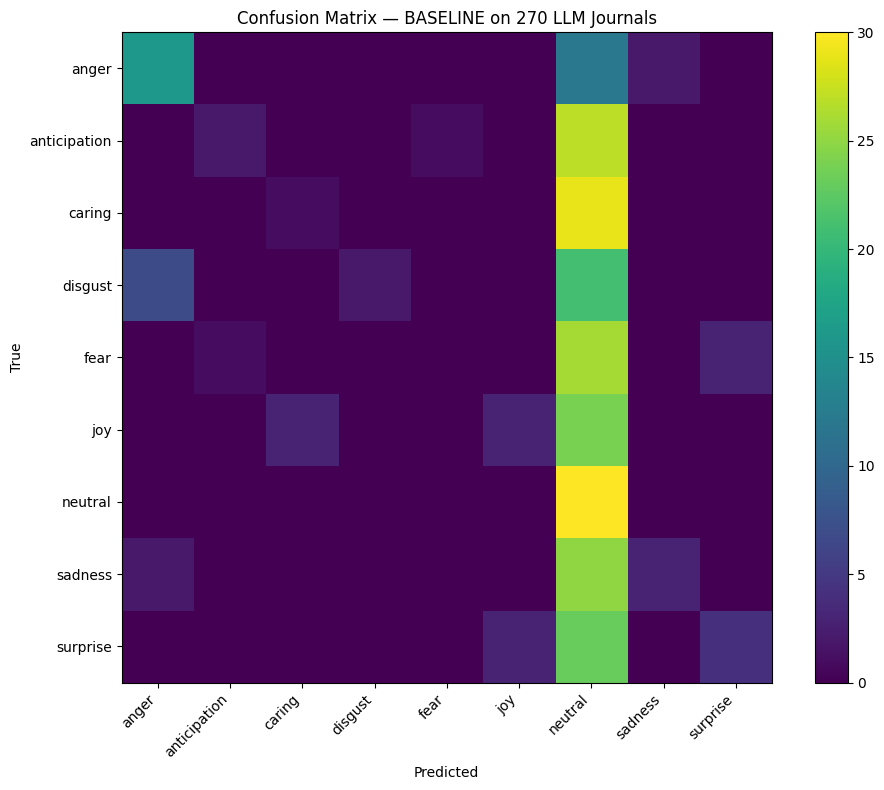


===== Recall delta (FINAL - BASELINE) =====
       anger  +0.367
anticipation  +0.900
      caring  +0.900
     disgust  +0.900
        fear  +1.000
         joy  +0.867
     neutral  -0.033
     sadness  +0.567
    surprise  +0.800


In [22]:
if baseline_model is None:
    print("No BASELINE_MODEL_PATH provided. Skipping baseline comparison.")
else:
    baseline_probs = predict_probs(baseline_tok, baseline_model, texts, batch_size=BATCH_SIZE)
    baseline_pred = baseline_probs.argmax(axis=-1)

    eval_hard(y_true, baseline_pred, title="BASELINE vs Teacher Hard Labels (270 journals)")
    cm_base = confusion_matrix(y_true, baseline_pred, labels=np.arange(NUM_LABELS))
    plot_cm(cm_base, "Confusion Matrix — BASELINE on 270 LLM Journals")

    # delta per-class recall
    rep_base = classification_report(y_true, baseline_pred, target_names=TARGET_LABELS, zero_division=0, output_dict=True)
    rep_final = classification_report(y_true, final_pred, target_names=TARGET_LABELS, zero_division=0, output_dict=True)

    print("\n===== Recall delta (FINAL - BASELINE) =====")
    for lab in TARGET_LABELS:
        d = rep_final[lab]["recall"] - rep_base[lab]["recall"]
        print(f"{lab:>12}  {d:+.3f}")
